#Data loading/processing

To do:
* want to download the data to this google colab notebook
* want to load the data in Pandas dataframe somehow
* want to create function that returns the x,y for train, test, validation

In [2]:
# create api key folder, download fruits360 dataset (https://www.kaggle.com/moltean/fruits), unzip to fruits dir
# the only thing you need to do to run this is upload the kaggle.json to the default folder
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d moltean/fruits

# unzip the data file
import zipfile
with zipfile.ZipFile("fruits.zip", 'r') as zip_ref:
    zip_ref.extractall("fruits")

100% 1.28G/1.28G [00:13<00:00, 108MB/s] 
100% 1.28G/1.28G [00:13<00:00, 105MB/s]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os

np.random.seed(1234)

In [3]:
def get_fruit360_data(directory, matches):
  X = []
  for t in os.listdir(directory):
    matched = False
    for match in matches:
      if match in t:
        matched = True
    if not matched:
      continue
    path = os.path.join(directory, t)
    for image in os.listdir(path):
      X.append(cv2.cvtColor(cv2.imread(os.path.join(path, image)), cv2.COLOR_BGR2LAB))
  return np.array(X) / 128 - 1 # normalize to -1..1 so that the NN can "use" more of itself TODO try without this

train_data = get_fruit360_data("fruits/fruits-360_dataset/fruits-360/Training/", ["Apple", "Pear", "Cherry"])
test_data = get_fruit360_data("fruits/fruits-360_dataset/fruits-360/Test/", ["Apple", "Pear", "Cherry"])
print(train_data.shape, test_data.shape)
# do we need to flatten these? probably

(15377, 100, 100, 3) (5135, 100, 100, 3)


In [4]:
# create X, Y from raw data
X_train = train_data[:,:,:,:1] # keep only L from LAB
X_test  = test_data [:,:,:,:1]
Y_train = train_data[:,:,:,1:] # keep AB from LAB
Y_test  = test_data [:,:,:,1:]
print(X_train.shape, Y_train.shape)
print(np.min(X_train), np.max(X_train), np.median(X_train)) #min, max, median brightness should be around -1,1,0

(15377, 100, 100, 1) (15377, 100, 100, 2)
-1.0 0.9921875 0.1875


10 255 147.0
(100, 100, 3)


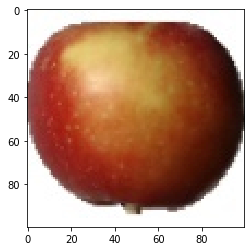

In [5]:
img = (train_data[0] + 1) * 128 # go from -1,1 to 0,256
img = img.astype("uint8")
print(np.min(img), np.max(img), np.median(img))
print(img.shape)
plt.imshow(np.array(cv2.cvtColor(img, cv2.COLOR_LAB2RGB)), interpolation='nearest')
plt.show()

Now we want to create, train and evaluate a model on this data

#Custom CNN implementation in LAB colorspace

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb

Custom model:

In [7]:
# create model

model = Sequential()
model.add(Conv2D(16, 5, input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]), # (100, 100, 1)
                data_format="channels_last",
                activation='relu', kernel_initializer='he_normal',
                padding='same'))
model.add(Conv2D(16, 5, activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(MaxPool2D(padding='same'))
model.add(Conv2D(12, 5, activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(Conv2D(9, 5, activation='relu', kernel_initializer='he_normal', padding='same',strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, 3, activation='tanh', kernel_initializer='he_normal', padding='same'))
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 16)      6416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 12)        4812      
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 9)         2709      
                                                                 
 up_sampling2d (UpSampling2D  (None, 50, 50, 9)        0         
 )                                                      

Based on the results and size of the InceptionV3 net, we can already tell that this number of parameters is way too small to be successful. However, because we can't afford more training time, these poor results will have to do. This could be improved in the future by adding more layers and more filters.

We experimented with several filter counts and layer counts, and these worked well for our purposes.

In [9]:
# train model
es = EarlyStopping(monitor='val_loss', 
                   patience=5, verbose=1,
                   restore_best_weights=True)
model.fit(X_train, Y_train, epochs=1, 
          callbacks=[es],
          batch_size=128, shuffle=True,  
          validation_split=0.2)

97/97 [==============================] - 675s 7s/step - loss: 0.0279 - val_loss: 0.0156


In [10]:
# evaluate model quantitatively, naively (no special metrics for images)
model.evaluate(X_test, Y_test)

161/161 [==============================] - 55s 339ms/step - loss: 0.0151


0.015120144933462143

## Qualitative testing

In [11]:
def combine_lab(gray_imgs, ab_imgs):
  n = min(len(gray_imgs), len(ab_imgs))
  imgs = np.zeros((n, 100, 100, 3))
  imgs[:, :, :, :1] = gray_imgs[0:n:]
  imgs[:, :, :, 1:] = ab_imgs[0:n:]
  imgs = imgs.astype("uint8")
  converted_imgs = []
  for i in range(0, n):
      converted_imgs.append(cv2.cvtColor(imgs[i], cv2.COLOR_LAB2RGB))
  converted_imgs = np.array(converted_imgs)
  return converted_imgs

In [87]:
n = 3500 # which image we want to see

In [88]:
img_X = X_test[n:n+1] # input L in -1,1
img_Y_pred = model.predict(img_X) # output AB in -1,1

# the black and white RGB version
img_bw = (test_data[n] + 1) * 128
img_bw = img_bw.astype("uint8")
img_bw = np.array(rgb2gray(cv2.cvtColor(img_bw, cv2.COLOR_LAB2RGB)))
img_bw_3d = np.zeros((100,100,3))
img_bw_3d[...,0] = img_bw
img_bw_3d[...,1] = img_bw
img_bw_3d[...,2] = img_bw
img_bw = img_bw_3d
print(img_bw_3d.shape)
# the predicted color RGB version
img_color_pred = combine_lab((X_test[n:n+1] + 1) * 128, (img_Y_pred + 1) * 128)[0]
print(img_color_pred.shape)
# the actual color RGB version
img_color_actual = (test_data[n] + 1) * 128
img_color_actual = img_color_actual.astype("uint8")
img_color_actual = np.array(cv2.cvtColor(img_color_actual, cv2.COLOR_LAB2RGB))
print(img_color_actual.shape)

(100, 100, 3)
(100, 100, 3)
(100, 100, 3)


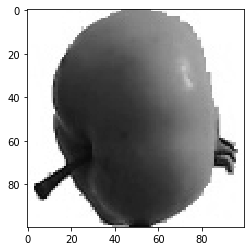

In [89]:
plt.imshow(img_bw, interpolation="nearest")
plt.show()

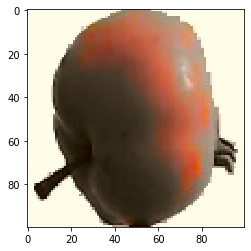

In [90]:
plt.imshow(img_color_pred, interpolation='nearest')
plt.show()

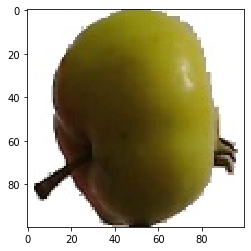

In [91]:
plt.imshow(img_color_actual, interpolation='nearest')
plt.show()